In [1]:
import nest_asyncio
from langgraph.graph import START, StateGraph, END
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
from typing import Literal
import os
from openai import OpenAI
from dotenv import load_dotenv
from nodes import network_gathering_node, memory_summarizer_node, graph_and_exploitation_inference_node, exposure_manager_node, event_summarizer_node, firewall_node, save_iteration_node
from configuration.state import HoneypotStateReact
from configuration import memory
nest_asyncio.apply()
import benchmark.benchmark as b


def display_graph(graph, width=300, height=300):

    png_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)

    display(Image(data=png_bytes, format="png", width=width, height=height)
)

def is_api_key_valid():
    try:
        client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
        response = client.responses.create(
            model="gpt-5",
            instructions="Test API key",
            input="Test API key",
            max_output_tokens=16,
            timeout=10
            )
    except Exception as e:
        print(f"Error: {e}")
        return False
    else:
        return True

/home/c0ff3k1ll3r/Desktop/Thesis/AI_Agent_for_honeypot_operations/HoneypotAgentApp/MultiAgentArchitecture/prompts/inference_and_exploitation_prompt.py:45: SyntaxWarning: invalid escape sequence '\`'
  Use this ordered set when classifying edges. Higher phases strictly subsume lower ones for the same \`(from, to)\` pair:


In [2]:
# Load environment variables
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
#  Check the validity of the API key
api_key_valid = is_api_key_valid()
print("API key is valid:", api_key_valid)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"


API key is valid: True


In [3]:
def should_continue_from_firewall(state: HoneypotStateReact) -> Literal["tools_firewall", "persistence_node"]:
    if hasattr(state, 'firewall_action'):
        return "tools_firewall"
    
    return "persistence_node"

In [4]:
def build_react_graph():
    graph = StateGraph(HoneypotStateReact)
    
    # Add nodes (remove save_iteration node)
    graph.add_node("network_gathering", network_gathering_node.network_gathering)
    graph.add_node("memory_summarizer", memory_summarizer_node.memory_summarizer)
    graph.add_node("event_summarizer", event_summarizer_node.event_summarizer)
    graph.add_node("graph_and_exploitation_inference", graph_and_exploitation_inference_node.graph_and_exploitation_inference)
    graph.add_node("exposure_manager", exposure_manager_node.exposure_manager)
    graph.add_node("firewall_manager", firewall_node.firewall_executor)
    graph.add_node("persistence_node", save_iteration_node.save_iteration)
    graph.add_node("tools_firewall", firewall_node.tools_firewall)
 

    # Define execution order
    graph.add_edge(START, "network_gathering")
    graph.add_edge(START, "memory_summarizer")
    graph.add_edge("network_gathering", "event_summarizer")
    graph.add_edge("event_summarizer", "graph_and_exploitation_inference")
    graph.add_edge(["graph_and_exploitation_inference", "memory_summarizer"], "exposure_manager")
    graph.add_edge("exposure_manager", "firewall_manager")
    graph.add_conditional_edges("firewall_manager", should_continue_from_firewall)
    graph.add_edge("tools_firewall", "persistence_node")
    graph.add_edge("persistence_node", END)

        
    return graph.compile()

INFO:pyppeteer.launcher:Browser listening on: ws://127.0.0.1:34947/devtools/browser/f1bcada9-6407-47e9-933c-1baed0ae8248
INFO:pyppeteer.launcher:terminate chrome process...


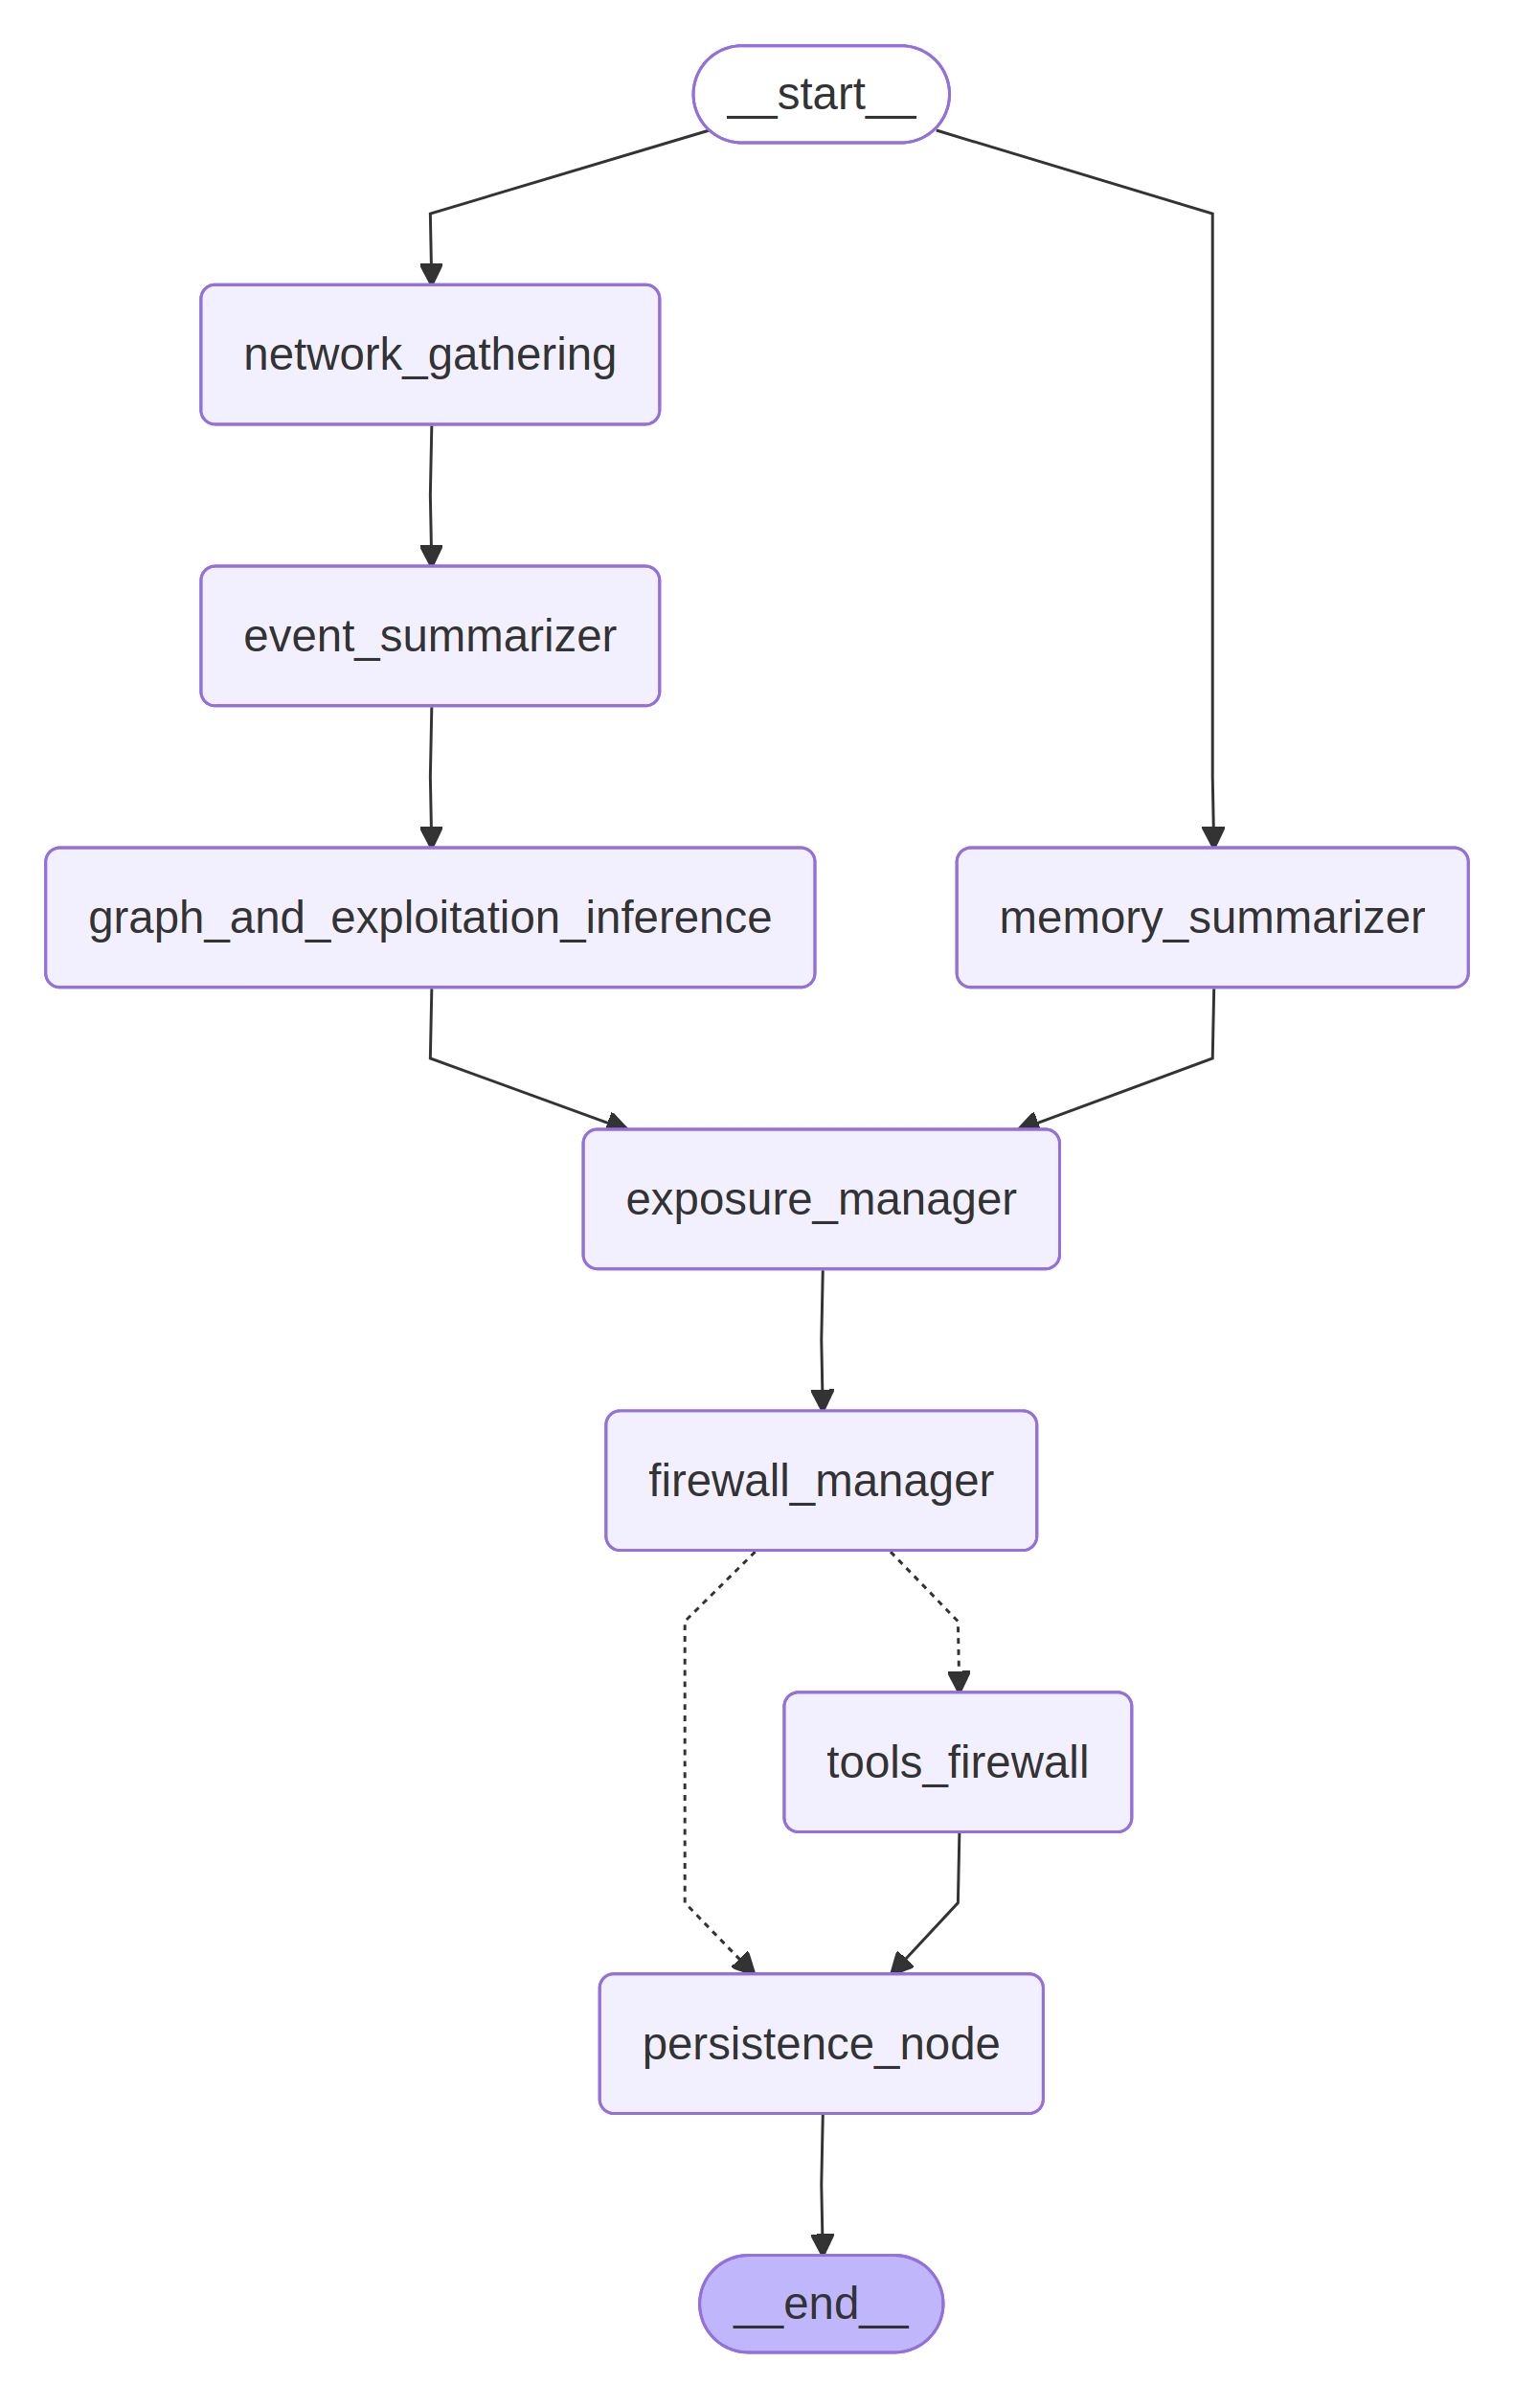

In [5]:
graph = build_react_graph()
display_graph(graph)

## Single Iteration

In [6]:
episodic_memory = memory.EpisodicMemory()


In [7]:
responses = []
for i in range(2):
    initial_state = HoneypotStateReact(
        messages=[]
    )
    response = await graph.ainvoke(initial_state, config={"configurable": {"store" : episodic_memory, "prompt":"fast", "time_window":2, "epoch_num":i+1}})
    responses.append(response)

INFO:nodes.memory_summarizer_node:Memory Agent
INFO:nodes.memory_summarizer_node:1
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes.network_gathering_node:Network gathering Node
INFO:nodes.event_summarizer_node:Summarizer Agent
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes.attack_and_exploitation_node:Inference Agent
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes.exploitation_manager_node:Exploitation Agent
INFO:nodes.exploitation_manager_node:Previously exposed: []
INFO:nodes.exploitation_manager_node:Exposure registry: {}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes.firewall_node:Firewall Agent
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 2

In [8]:
for response in responses:
    for m in response['messages']:
        m.pretty_print()

================================ Human Message =================================

No honeypot exposure or exploitation activity recorded in epoch 1; no policy deviations or anomalies.
================================ Human Message =================================

Threat Overview:
- Attack Volume: 0 alerts in the last 2 minutes
- High-Severity Alerts: No evidence found.
- Primary Attack Types: No evidence found.
- Threat Level: Low (no recent alert activity)

Source Analysis:
- Top Attacking IPs: No evidence found.

Target Analysis:
- cve-2021-22205-gitlab-1-proxy:
  - Targeted Services: No evidence found.
  - Honeypot Engagement: No evidence found.
  - Compromise Indicators: No evidence found.
- s2-057-struts2-1:
  - Targeted Services: No evidence found.
  - Honeypot Engagement: No evidence found.
  - Compromise Indicators: No evidence found.
- unauthorized-rce-docker-1:
  - Targeted Services: No evidence found.
  - Honeypot Engagement: No evidence found.
  - Compromise Indicators: N

In [9]:
for i in episodic_memory.get_recent_iterations():
    for k,v in i.value.items():
        print(f"Key: {k}\nValue: {v}")

Key: id
Value: iteration_1
Key: iteration_number
Value: 1
Key: timestamp
Value: 1755083874
Key: datetime
Value: 2025-08-13T13:17:54.548491
Key: memory_context
Value: No honeypot exposure or exploitation activity recorded in epoch 1; no policy deviations or anomalies.
Key: currently_exposed
Value: {'ip': '172.20.0.10', 'service': 'cve-2021-22205-gitlab-1-proxy', 'current_level': 0, 'epoch': 1}
Key: exposure_registry
Value: {'172.20.0.10': {'service': 'cve-2021-22205-gitlab-1-proxy', 'first_epoch': 1, 'last_epoch': 1, 'epochs_exposed': 0, 'last_level': 0, 'prev_level': 0}}
Key: rules_added
Value: []
Key: honeypots_exploitation
Value: [{'ip': '172.20.0.10', 'service': 'cve-2021-22205-gitlab-1-proxy', 'level_prev': 0, 'level_new': 0, 'changed': False, 'evidence_quotes': ['No evidence found.']}, {'ip': '172.20.0.3', 'service': 's2-057-struts2-1', 'level_prev': 0, 'level_new': 0, 'changed': False, 'evidence_quotes': ['No evidence found.']}, {'ip': '172.20.0.2', 'service': 'unauthorized-rce-d

## Benchmark

In [ ]:
{
  "reasoning": "string — explain selection according to policy",
  "selected_honeypot": {
    "ip": "string",
    "service": "string",
    "current_level": 0|33|66|100
  },
  "why_not_expose": [
    {"ip": "string", "reason": "string"}
  ],
  "plan": {
    "allow": [
      {"src": "CIDR or IP", "dst": "IP", "ports": "any|int|range", "proto": "tcp|udp"}
    ],
    "remove": [
      {"src": "CIDR or IP", "dst": "CIDR or IP"}
    ],
    "block": [
      {"src": "CIDR or IP", "dst": "CIDR or IP"}
    ]
  },
  "lockdown": bool
}

In [8]:
episodic_memory = memory.EpisodicMemory()

config_dict = {
            "max_epochs": 20,
            "attack_duration": 150,
            "monitor_accumulation_wait": 50,
            "firewall_update_wait": 2,
            "between_epoch_wait": 1,
            "stop_on_lockdown": True,
            "dir_name": "Struts_Gitlab_2_decoys_eve"
        }
runner = b.BenchmarkRunner(config_dict, episodic_memory=episodic_memory)
initial_state = HoneypotStateReact(
    messages=[]
)
responses = []
async def my_agent_executor(epoch_num: int):
    response = await graph.ainvoke(initial_state, config={
        "configurable": 
            {
            "store" : episodic_memory, 
            "time_window":2, 
            "prompt":"eve",
            "epoch_num": epoch_num,
            "model_name": "gpt-5"
            }
        }
    )
    responses.append(response)
    return response
    

results = runner.run(my_agent_executor)

INFO:benchmark.benchmark.Orchestrator:Starting benchmark run
INFO:benchmark.benchmark.AttackerController:Found existing attacker container: attacker
INFO:benchmark.benchmark.AttackerController:Successfully connected to attacker container
INFO:benchmark.benchmark.Orchestrator:
INFO:benchmark.benchmark.Orchestrator:EPOCH 1 STARTING
INFO:benchmark.benchmark.Orchestrator:============================================================

INFO:benchmark.benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.benchmark.Orchestrator:Starting attacker script with a fallback timeout of 150s...
INFO:benchmark.benchmark.AttackerController:[ATTACK-1] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.benchmark.AttackerController:[ATTACK-1] ['/attacker/scripts/manager_exploit.py', '1']
INFO:benchmark.benchmark.AttackerController:[ATTACK-1] [*] Launching exploit manager...
INFO:benchmark.benchmark.AttackerController:[ATTA

KeyboardInterrupt: 

In [ ]:
for i, response in enumerate(responses):
    
    print("=" * 130)
    print(f"Epoch: {i+1}")
    for m in response['messages']:
        m.pretty_print()
    print("-" * 130)

Epoch: 1
================================ Human Message =================================

There is no exploitation plan memory for the last epoch; this is the first epoch. No honeypots have been exposed yet.
================================ Human Message =================================

Threat Overview:

- Attack Volume: 0 alerts in the last 2 minutes
- High-Severity Alerts: No evidence found.
- Primary Attack Types: No evidence found.
- Threat Level: Low (no alert activity detected)

Source Analysis:

- Top Attacking IPs: No evidence found.

Target Analysis:

- Honeypot: cve-2014-6271-web-1
  - Targeted Services: No evidence found.
  - Honeypot Engagement: No evidence found.
  - Compromise Indicators: No evidence found.

- Honeypot: cve-2015-5254-activemq-1
  - Targeted Services: No evidence found.
  - Honeypot Engagement: No evidence found.
  - Compromise Indicators: No evidence found.

- Honeypot: cve-2021-22205-gitlab-1-proxy
  - Targeted Services: No evidence found.
  - Honeypo

In [ ]:
for n,i in enumerate(episodic_memory.get_recent_iterations(limit=20)):
    print(f"Epoch: {n}")
    for k,v in i.value.items():
        if k == "exploitation_strategy":
            print(f"Key: {k}\nValue: \n{v}")
    print("=" * 130)


Epoch: 0
Key: exploitation_strategy
Value: 
{'allow': [{'src': '192.168.100.0/24', 'dst': '172.20.0.10', 'ports': 'any', 'proto': 'tcp'}], 'remove': [], 'block': []}
Epoch: 1
Key: exploitation_strategy
Value: 
{'allow': [{'src': '192.168.100.0/24', 'dst': '172.20.0.10', 'ports': 'any', 'proto': 'tcp'}], 'remove': [{'src': '192.168.100.0/24', 'dst': '172.20.0.3'}, {'src': '192.168.100.0/24', 'dst': '172.20.0.2'}, {'src': '192.168.100.0/24', 'dst': '172.20.0.7'}], 'block': [{'src': '192.168.100.0/24', 'dst': '172.20.0.3'}, {'src': '192.168.100.0/24', 'dst': '172.20.0.2'}, {'src': '192.168.100.0/24', 'dst': '172.20.0.7'}]}
Epoch: 2
Key: exploitation_strategy
Value: 
{'allow': [{'src': '192.168.100.0/24', 'dst': '172.20.0.3', 'ports': 'any', 'proto': 'tcp'}], 'remove': [{'src': '192.168.100.0/24', 'dst': '172.20.0.10'}], 'block': [{'src': '192.168.100.0/24', 'dst': '172.20.0.2'}, {'src': '192.168.100.0/24', 'dst': '172.20.0.7'}]}
Epoch: 3
Key: exploitation_strategy
Value: 
{'allow': [{'src